In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/adc-4-0-social-o-scope/train.csv
/kaggle/input/adc-4-0-social-o-scope/test.csv


### upload the library 

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, SpatialDropout1D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

In [ ]:

# Load the dataset
df1 = pd.read_csv('/kaggle/input/the-best-youu/df_final0123.csv')

# Check class distribution
print(df1['Statut'].value_counts())

# Convert labels to numerical values
label_map = {'Positif': 0, 'Négatif': 1, 'Neutre': 2}
df1['label'] = df1['Statut'].map(label_map)
df1 = df1.dropna()
# Split data
X = df1['Commentaire']
y = df1['label']


Statut
Positif    22226
Négatif    20044
Neutre     17865
Name: count, dtype: int64


*e**xt vectorazation*****

In [ ]:
# Sample data (replace with your actual data)
texts = df1['Commentaire'].tolist()
labels = df1['Statut'].values  # Ensure these are integer-encoded

# 1. Tokenization and Vocabulary
tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>', filters='', lower=False)
tokenizer.fit_on_texts(texts)

vocab_size = len(tokenizer.word_index) + 1
print(f"Vocabulary size: {vocab_size}")

# 2. Sequence Creation and Padding
sequences = tokenizer.texts_to_sequences(texts)
max_len = 128
padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')

# 3. Split data with stratification
X_train, X_val, y_train, y_val = train_test_split(
    padded_sequences, 
    labels, 
    test_size=0.2, 
    stratify=labels,  # Crucial for maintaining class distribution
    random_state=42
)

In [8]:
X_train_pad

array([[1238, 1011,    9, ...,    0,    0,    0],
       [   4,    8,  435, ...,    0,    0,    0],
       [ 652, 2964,  436, ...,    0,    0,    0],
       ...,
       [8657,    0,    0, ...,    0,    0,    0],
       [ 397,  225, 8658, ...,    0,    0,    0],
       [  22, 8659,    9, ...,    0,    0,    0]], dtype=int32)

In [ ]:
#. Get all possible classes from FULL dataset
all_classes = np.unique(labels)
print(f"All classes in dataset: {all_classes}")

#. Calculate class weights using all possible classes
class_weights = compute_class_weight(
    'balanced', 
    classes=all_classes, 
    y=labels  # Use full dataset, not just training split
)
class_weights_dict = dict(zip(all_classes, class_weights))
print("Class weights:", class_weights_dict)

# . Enhanced model architecture
model = Sequential([
    Embedding(input_dim=vocab_size, 
              output_dim=256,
              input_length=max_len,
              mask_zero=True),
    
    SpatialDropout1D(0.4),
    
    Bidirectional(LSTM(128, 
                       return_sequences=True,
                       recurrent_dropout=0.2)),
    Dropout(0.5),
    
    Bidirectional(LSTM(64,
                       recurrent_dropout=0.2)),
    Dropout(0.5),
    
    Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.4),
    
    Dense(3, activation='softmax')  # 3 output classes
])

# . Custom optimizer
optimizer = Adam(learning_rate=0.001, clipnorm=1.0)

model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

# . Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
]

# . Train the model
history = model.fit(
    X_train, y_train,
    epochs=5,
    batch_size=64,
    validation_data=(X_val, y_val),
    callbacks=callbacks,
    class_weight=class_weights_dict,  # Use the calculated weights
    verbose=1
)

# . Evaluate the model
test_loss, test_acc = model.evaluate(X_val, y_val, verbose=0)
print(f"\nValidation Accuracy: {test_acc:.4f}, Validation Loss: {test_loss:.4f}")

Vocabulary size: 76566
All classes in dataset: [0. 1. 2.]
Class weights: {0.0: 1.0346188112511137, 1.0: 0.8744809483852923, 2.0: 1.1236902490945786}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout1d_2                  │ ?                           │               0 │
│ (SpatialDropout1D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_4 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_5 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
509/509 ━━━━━━━━━━━━━━━━━━━━ 626s 1s/step - accuracy: 0.5938 - loss: 1.2353 - val_accuracy: 0.7403 - val_loss: 0.6378 - learning_rate: 0.0010
Epoch 2/5
283/509 ━━━━━━━━━━━━━━━━━━━━ 4:15 1s/step - accuracy: 0.7962 - loss: 0.5526

In [9]:
history = model.fit(X_train_pad, y_train,
                    epochs=5,
                    batch_size=64,
                    validation_data=(X_test_pad, y_test))

Epoch 1/5


I0000 00:00:1753538955.484112      99 cuda_dnn.cc:529] Loaded cuDNN version 90300


753/753 ━━━━━━━━━━━━━━━━━━━━ 153s 191ms/step - accuracy: 0.3732 - loss: nan - val_accuracy: 0.3623 - val_loss: nan
Epoch 2/5
753/753 ━━━━━━━━━━━━━━━━━━━━ 143s 190ms/step - accuracy: 0.3710 - loss: nan - val_accuracy: 0.3623 - val_loss: nan
Epoch 3/5
 99/753 ━━━━━━━━━━━━━━━━━━━━ 1:52 172ms/step - accuracy: 0.3592 - loss: nan

KeyboardInterrupt: 

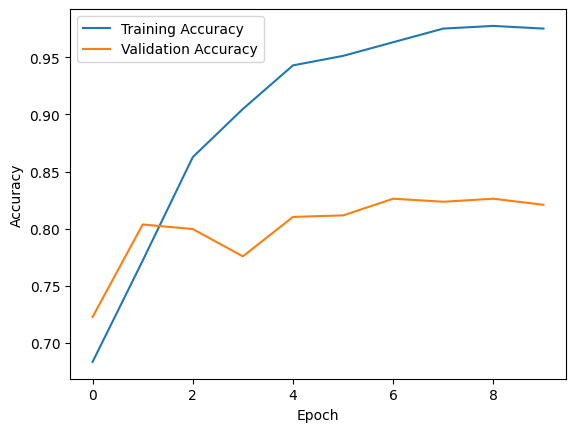

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8064 - loss: 0.7808
Test Accuracy: 82.10%


In [12]:
import matplotlib.pyplot as plt

# Plot training history
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Evaluate on test set
loss, accuracy = model.evaluate(X_test_pad, y_test)
print(f'Test Accuracy: {accuracy*100:.2f}%')

### train the data without split


In [ ]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l2
import joblib

# 1. Load and preprocess training data
train_df = pd.read_csv('/kaggle/input/adc-4-0-social-o-scope/train.csv')
train_df['Commentaire'] = train_df['Commentaire'].fillna('').astype(str)

# Create label mapping
label_map = {'Positif': 0, 'Négatif': 1, 'Neutre': 2}
reverse_label_map = {v: k for k, v in label_map.items()}  # Define reverse mapping

train_df['label'] = train_df['Statut'].map(label_map)


In [5]:
# 2. Tokenization and sequencing
tokenizer = Tokenizer(num_words=150000)
tokenizer.fit_on_texts(train_df['Commentaire'])

X_train_seq = tokenizer.texts_to_sequences(train_df['Commentaire'])
X_train_pad = pad_sequences(X_train_seq, maxlen=100, padding='post', truncating='post')
y_train = train_df['label'].values


In [6]:

# 3. Build and train model
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 128

model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=100),
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.5),
    Bidirectional(LSTM(32)),
    Dropout(0.5),
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    Dense(3, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(X_train_pad, y_train, epochs=10, batch_size=64)

Epoch 1/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - accuracy: 0.4278 - loss: nan
Epoch 2/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.4295 - loss: nan
Epoch 3/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.4307 - loss: nan
Epoch 4/10
104/314 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.4377 - loss: nan

KeyboardInterrupt: 

In [20]:
# 4. Save model and artifacts
model.save('sentiment_model.h5')
joblib.dump(tokenizer, 'tokenizer.joblib')
joblib.dump(label_map, 'label_map.joblib')


['label_map.joblib']

### Save modele and download

In [21]:
# Save model
model.save("sentiment_model.h5")

# Save tokenizer
import pickle
with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)


In [22]:
from IPython.display import FileLink

# Download the LSTM model
FileLink("sentiment_model.h5")


/kaggle/working/sentiment_model.h5

In [23]:
from IPython.display import FileLink

# Create download links
FileLink("sentiment_model.h5")
FileLink("tokenizer.pkl")


/kaggle/working/tokenizer.pkl

In [2]:
# 5. Load new test dataset
test_df = pd.read_csv('/kaggle/input/adc-4-0-social-o-scope/test.csv')  # Replace with your test file path
test_df['Commentaire'] = test_df['Commentaire'].fillna('').astype(str)


In [26]:
# 6. Load artifacts for prediction
model = load_model('sentiment_model.h5')
tokenizer = joblib.load('tokenizer.joblib')
label_map = joblib.load('label_map.joblib')
reverse_label_map = {v: k for k, v in label_map.items()}  # Recreate reverse mapping

### test data set

In [3]:
# 7. Preprocess test data
X_test_seq = tokenizer.texts_to_sequences(test_df['Commentaire'])
X_test_pad = pad_sequences(X_test_seq, maxlen=100, padding='post', truncating='post')

AttributeError: BertTokenizerFast has no attribute texts_to_sequences

In [28]:
# 8. Predict on test set
y_pred_probs = model.predict(X_test_pad)
y_pred = np.argmax(y_pred_probs, axis=1)


29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


In [29]:
# 9. Add predictions to test dataframe
test_df['Predicted_Statut'] = [reverse_label_map[pred] for pred in y_pred]
test1 = test_df.drop(['Commentaire'],axis = 1)


In [32]:
# 10. Save predictions
test1.to_csv('test_predictions102.csv', index=False)
print("Predictions saved to 'test_predictions.csv'")

Predictions saved to 'test_predictions.csv'
